In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_master = pd.read_csv('master_df_301_fp3.csv')
df_master.head()

,project_name,url,project_id,sdtc,mcpc,mcve,star_number,commit_count,files,lines,pull_requests,github_repo_creation,earliest_commit,most_recent_commit,committer_count,author_count,domainant_domain,dominant_domain_committer_commits,dominant_domain_author_commits,dominant_domain_committers,dominant_domain_authors,cik,fg500,sec10k,sec20f,owner_login,company_name,owner_company,license,names,TypeScript,JavaScript,CSS,Inno Setup,HTML,Shell,Batchfile,SCSS,PowerShell,Groovy,...,2020-06-14 00:00:00,2020-06-21 00:00:00,2020-06-28 00:00:00,2020-07-05 00:00:00,2020-07-12 00:00:00,2020-07-19 00:00:00,2020-07-26 00:00:00,2020-08-02 00:00:00,2020-08-09 00:00:00,2020-08-16 00:00:00,2020-08-23 00:00:00,2020-08-30 00:00:00,2020-09-06 00:00:00,2020-09-13 00:00:00,2020-09-20 00:00:00,2020-09-27 00:00:00,2020-10-04 00:00:00,2020-10-11 00:00:00,2020-10-18 00:00:00,2020-10-25 00:00:00,2020-11-01 00:00:00,2020-11-08 00:00:00,2020-11-15 00:00:00,2020-11-22 00:00:00,2020-11-29 00:00:00,2020-12-06 00:00:00,2020-12-13 00:00:00,2020-12-20 00:00:00,2020-12-27 00:00:00,2021-01-03 00:00:00,2021-01-10 00:00:00,2021-01-17 00:00:00,2021-01-24 00:00:00,2021-01-31 00:00:00,2021-02-07 00:00:00,2021-02-14 00:00:00,2021-02-21 00:00:00,2021-02-28 00:00:00,2021-03-07 00:00:00,2021-03-14 00:00:00
0,vscode,https://github.com/Microsoft/vscode,28947324,t,t,t,80406,55145,4210.0,1164007.0,5232,2015-09-03 20:23:38,2015-11-13 12:39:38,2019-05-31 22:11:06,831,1099,microsoft.com,43230,45274,54,323,789019.0,t,t,f,Microsoft,MICROSOFT CORPORATION,NaN,MIT,"['editor', 'electron', 'visual-studio-code', '...",33176739.0,1210742.0,549832.0,277637.0,160965.0,33728.0,8271.0,6732.0,6519.0,3928.0,...,320,326,236,222,245,259,173,201,227,190,241,258,296,279,192,212,184,160,243,272,281,323,257,292,220,247,406,139,66,290,322,329,249,378,392,404,328,363,261,39
1,swift,https://github.com/apple/swift,29261651,t,f,f,51911,85545,NaN,NaN,24225,2015-10-23 21:15:07,2010-07-17 23:50:59,2019-05-31 23:32:06,805,912,apple.com,27079,34637,80,276,320193.0,t,t,f,Apple,APPLE INC,NaN,Apache-2.0,[],NaN,NaN,NaN,NaN,NaN,198065.0,15028.0,NaN,NaN,NaN,...,140,128,174,138,150,170,165,166,166,128,161,158,145,96,189,134,165,141,156,149,147,169,164,26,144,147,115,70,38,129,173,144,175,191,219,138,192,180,107,9
2,TypeScript,https://github.com/Microsoft/TypeScript,10941284,t,t,t,51745,41276,53969.0,4923142.0,9175,2014-06-17 15:28:39,2014-07-07 22:08:16,2019-05-31 23:19:27,459,544,microsoft.com,18443,21455,29,121,789019.0,t,t,f,Microsoft,MICROSOFT CORPORATION,NaN,Apache-2.0,"['typescript', 'javascript', 'language', 'type...",105161345.0,175.0,NaN,NaN,NaN,47.0,NaN,NaN,2855.0,NaN,...,42,34,33,53,27,17,21,27,15,38,24,28,43,34,44,33,51,21,29,43,37,24,14,21,35,26,29,10,11,31,26,20,22,27,22,29,26,36,32,2
3,spring-boot,https://github.com/spring-projects/spring-boot,4952344,t,f,f,39634,22099,6242.0,574034.0,3365,2012-10-19 15:02:57,2013-07-24 10:28:30,2019-05-31 22:17:55,278,741,pivotal.io,19061,17226,21,615,1574135.0,f,t,f,spring-projects,NaN,NaN,Apache-2.0,"['java', 'spring-boot', 'spring', 'framework']",NaN,37722.0,450.0,NaN,70165.0,43188.0,2141.0,NaN,NaN,26659.0,...,80,64,38,41,51,146,59,111,98,38,56,21,62,148,47,51,35,82,65,172,43,64,21,9,28,154,44,28,4,36,115,95,30,28,98,101,46,34,36,29
4,element,https://github.com/ElemeFE/element,44989079,f,f,t,39620,5317,1069.0,177763.0,3662,2016-09-03 06:19:26,2016-07-27 06:15:02,2019-05-31 09:06:40,209,570,ele.me,53,63,6,8,NaN,NaN,NaN,NaN,ElemeFE,NaN,NaN,MIT,"['vue', 'components', 'javascript', 'vue-compo...",NaN,520947.0,NaN,NaN,NaN,3901.0,NaN,273118.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,12,0,10,0,0,0,0,1,0,4,1,4,1,1,4,0,0,4,0,0,0


In [ ]:
# languages used: TypeScript, C++, Java, Scala, Swift, Python, JavaScript, HTML, C

In [ ]:
# retrieving a list of all possible languages, tools and technologies used in all repos

languages = df_master.loc[:,'TypeScript':'Liquid'].columns

In [ ]:
# filtering out to only 9 of the most popular languages.

df_master.drop([lang for lang in languages if lang not in ['TypeScript','C++','Java','Scala','Swift','Python',
                                      'JavaScript','HTML','C']],axis=1,inplace=True)

df_master.head()

,project_name,url,project_id,sdtc,mcpc,mcve,star_number,commit_count,files,lines,pull_requests,github_repo_creation,earliest_commit,most_recent_commit,committer_count,author_count,domainant_domain,dominant_domain_committer_commits,dominant_domain_author_commits,dominant_domain_committers,dominant_domain_authors,cik,fg500,sec10k,sec20f,owner_login,company_name,owner_company,license,names,TypeScript,JavaScript,HTML,C++,Python,C,Java,Swift,Scala,HCL,...,2020-06-14 00:00:00,2020-06-21 00:00:00,2020-06-28 00:00:00,2020-07-05 00:00:00,2020-07-12 00:00:00,2020-07-19 00:00:00,2020-07-26 00:00:00,2020-08-02 00:00:00,2020-08-09 00:00:00,2020-08-16 00:00:00,2020-08-23 00:00:00,2020-08-30 00:00:00,2020-09-06 00:00:00,2020-09-13 00:00:00,2020-09-20 00:00:00,2020-09-27 00:00:00,2020-10-04 00:00:00,2020-10-11 00:00:00,2020-10-18 00:00:00,2020-10-25 00:00:00,2020-11-01 00:00:00,2020-11-08 00:00:00,2020-11-15 00:00:00,2020-11-22 00:00:00,2020-11-29 00:00:00,2020-12-06 00:00:00,2020-12-13 00:00:00,2020-12-20 00:00:00,2020-12-27 00:00:00,2021-01-03 00:00:00,2021-01-10 00:00:00,2021-01-17 00:00:00,2021-01-24 00:00:00,2021-01-31 00:00:00,2021-02-07 00:00:00,2021-02-14 00:00:00,2021-02-21 00:00:00,2021-02-28 00:00:00,2021-03-07 00:00:00,2021-03-14 00:00:00
0,vscode,https://github.com/Microsoft/vscode,28947324,t,t,t,80406,55145,4210.0,1164007.0,5232,2015-09-03 20:23:38,2015-11-13 12:39:38,2019-05-31 22:11:06,831,1099,microsoft.com,43230,45274,54,323,789019.0,t,t,f,Microsoft,MICROSOFT CORPORATION,NaN,MIT,"['editor', 'electron', 'visual-studio-code', '...",33176739.0,1210742.0,160965.0,3251.0,2405.0,818.0,599.0,284.0,NaN,NaN,...,320,326,236,222,245,259,173,201,227,190,241,258,296,279,192,212,184,160,243,272,281,323,257,292,220,247,406,139,66,290,322,329,249,378,392,404,328,363,261,39
1,swift,https://github.com/apple/swift,29261651,t,f,f,51911,85545,NaN,NaN,24225,2015-10-23 21:15:07,2010-07-17 23:50:59,2019-05-31 23:32:06,805,912,apple.com,27079,34637,80,276,320193.0,t,t,f,Apple,APPLE INC,NaN,Apache-2.0,[],NaN,NaN,NaN,41487955.0,1810011.0,322731.0,NaN,35798323.0,NaN,NaN,...,140,128,174,138,150,170,165,166,166,128,161,158,145,96,189,134,165,141,156,149,147,169,164,26,144,147,115,70,38,129,173,144,175,191,219,138,192,180,107,9
2,TypeScript,https://github.com/Microsoft/TypeScript,10941284,t,t,t,51745,41276,53969.0,4923142.0,9175,2014-06-17 15:28:39,2014-07-07 22:08:16,2019-05-31 23:19:27,459,544,microsoft.com,18443,21455,29,121,789019.0,t,t,f,Microsoft,MICROSOFT CORPORATION,NaN,Apache-2.0,"['typescript', 'javascript', 'language', 'type...",105161345.0,175.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42,34,33,53,27,17,21,27,15,38,24,28,43,34,44,33,51,21,29,43,37,24,14,21,35,26,29,10,11,31,26,20,22,27,22,29,26,36,32,2
3,spring-boot,https://github.com/spring-projects/spring-boot,4952344,t,f,f,39634,22099,6242.0,574034.0,3365,2012-10-19 15:02:57,2013-07-24 10:28:30,2019-05-31 22:17:55,278,741,pivotal.io,19061,17226,21,615,1574135.0,f,t,f,spring-projects,NaN,NaN,Apache-2.0,"['java', 'spring-boot', 'spring', 'framework']",NaN,37722.0,70165.0,NaN,NaN,NaN,19523039.0,NaN,NaN,NaN,...,80,64,38,41,51,146,59,111,98,38,56,21,62,148,47,51,35,82,65,172,43,64,21,9,28,154,44,28,4,36,115,95,30,28,98,101,46,34,36,29
4,element,https://github.com/ElemeFE/element,44989079,f,f,t,39620,5317,1069.0,177763.0,3662,2016-09-03 06:19:26,2016-07-27 06:15:02,2019-05-31 09:06:40,209,570,ele.me,53,63,6,8,NaN,NaN,NaN,NaN,ElemeFE,NaN,NaN,MIT,"['vue', 'components', 'javascript', 'vue-compo...",NaN,520947.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,12,0,10,0,0,0,0,1,0,4,1,4,1,1,4,0,0,4,0,0,0


In [ ]:
# converting the language variables to dummy variables.

for col in df_master.loc[:,'TypeScript':'Scala'].columns:
  df_master[col] = df_master[col].notna().map({
      False: 0,
      True: 1
  })

In [ ]:
# creating median weekly commit rate as a separate variable

first = df_master.columns[-52:][0]
last = df_master.columns[-52:][-1]

df_master['median_weekly_commits'] = df_master.loc[:,first:last].median(axis=1)

In [ ]:
# we plan on log transforming median_weekly_commits due to skewness, so we replace 0s with 1s to not get
# any -inf values.

df_master['median_weekly_commits'] = df_master['median_weekly_commits'].replace(0,1)

**Packages used**

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

**QUESTION 1: Based on certain features, how popular will an open source enterprise GitHub repository be ? We'll use linear regression first.**

Most of the data seems to be pretty right skewed, so we log transformed the quantitative predictors and response variable.

In [ ]:
# log transformations

df_master['log_star_number'] = np.log(df_master.star_number)
df_master['log_commit_count'] = np.log(df_master.commit_count)
df_master['log_pull_requests'] = np.log(df_master.pull_requests)
df_master['log_weekly_commits'] = np.log(df_master['median_weekly_commits'])

In [ ]:
# creating design matrix and response vector

X = df_master[['log_commit_count','log_pull_requests', 'log_weekly_commits',
              'TypeScript','JavaScript','HTML','C++','Python','C','Java','Swift','Scala']]
y = df_master.log_star_number

In [ ]:
# creating training and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# pipeline to scale and fit data. 

pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

pipeline.fit(X=X_train,y=y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [ ]:
pipeline['linearregression'].coef_

array([-0.00125208,  0.12971304,  0.15794685, -0.11294237,  0.03396781,
       -0.04764955, -0.10787271, -0.13682948,  0.16528325, -0.00974589,
       -0.01793999, -0.0776327 ])

In [ ]:
pipeline['linearregression'].intercept_

9.568526027295627

In [ ]:
y_test_ = pipeline.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_test_)

0.28573846128362546

**Question 2: (same as above but with KNN regressor)**

In [ ]:
# pipeline to scale and fit data

pipeline_knn = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=5)
)

In [ ]:
pipeline_knn.fit(X=X_train, y=y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsregressor',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=5, p=2,
                                     weights='uniform'))],
         verbose=False)

In [ ]:
y_test_knn_ = pipeline_knn.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_test_knn_)

0.2663534162912658

Based on the MSEs, it seems that the KNN regressor did a slightly better job of predicting the test data than the linear regressor did.

In [ ]:
# determining which number of neighbors yields best results based on grid searching algorithm

grid_search = GridSearchCV(pipeline_knn,
                           param_grid={
                               "kneighborsregressor__n_neighbors": range(1, 20)
                           },
                           scoring="neg_mean_squared_error",
                           cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsregressor',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=19, p=2,
                                     weights='uniform'))],
         verbose=False)

In [ ]:
# this block determines what set of features will yield most optimal results under n=19 neighbors.

def get_cv_error(features):
  temp = features.copy()
  ct = make_column_transformer(
    (StandardScaler(), temp),
    remainder="drop"
  )
  
  # define pipeline
  pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=19)
  ) 
  pipeline
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=df_master[features], 
                             y=df_master.log_star_number,
                             scoring="neg_mean_squared_error", cv=5)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()
for features in [['TypeScript','JavaScript','HTML','C++','Python','C','Java','Swift','Scala'],
                 ['log_commit_count', 'TypeScript','JavaScript','HTML','C++','Python','C','Java','Swift','Scala'],
                 ['log_pull_requests', 'TypeScript','JavaScript','HTML','C++','Python','C','Java','Swift','Scala'],
                 ['log_commit_count','log_pull_requests', 'TypeScript','JavaScript','HTML','C++','Python','C','Java','Swift','Scala'],
                 ['log_weekly_commits', 'TypeScript','JavaScript','HTML','C++','Python','C','Java','Swift','Scala'],
                 ['log_commit_count','log_pull_requests', 'log_weekly_commits', 'TypeScript','JavaScript','HTML','C++','Python','C','Java','Swift','Scala']]:
  errs[str(features)] = get_cv_error(features)

errs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


['TypeScript', 'JavaScript', 'HTML', 'C++', 'Python', 'C', 'Java', 'Swift', 'Scala']                                                                   0.322616
['log_commit_count', 'TypeScript', 'JavaScript', 'HTML', 'C++', 'Python', 'C', 'Java', 'Swift', 'Scala']                                               0.307927
['log_pull_requests', 'TypeScript', 'JavaScript', 'HTML', 'C++', 'Python', 'C', 'Java', 'Swift', 'Scala']                                              0.309865
['log_commit_count', 'log_pull_requests', 'TypeScript', 'JavaScript', 'HTML', 'C++', 'Python', 'C', 'Java', 'Swift', 'Scala']                          0.304517
['log_weekly_commits', 'TypeScript', 'JavaScript', 'HTML', 'C++', 'Python', 'C', 'Java', 'Swift', 'Scala']                                             0.313721
['log_commit_count', 'log_pull_requests', 'log_weekly_commits', 'TypeScript', 'JavaScript', 'HTML', 'C++', 'Python', 'C', 'Java', 'Swift', 'Scala']    0.305173
dtype: float64

The analysis shows that omitting just weekly commits will slightly improve the model (from .3051 to .3045), but not by a big amount.

In [ ]:
pipeline_knn2 = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=19)
)

pipeline_knn2.fit(X=X_train, y=y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsregressor',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=19, p=2,
                                     weights='uniform'))],
         verbose=False)

In [ ]:
y_test_knn_2 = pipeline_knn2.predict(X_test)

mean_squared_error(y_test,y_test_knn_2)

0.248194320496114

**Question 3: K-Means clustering**

In [ ]:
# scaling and fitting data into K-Means clustering.

pipeline_kmeans = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=2)
)

pipeline_kmeans.fit(X_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=2, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [ ]:
clusters = pipeline_kmeans['kmeans'].labels_

In [ ]:
pipeline_kmeans['kmeans'].cluster_centers_

array([[ 0.67996203,  0.67563265,  0.67490409,  0.25009975,  0.27932778,
         0.46067398,  0.38563237,  0.5433744 ,  0.40862722,  0.16021578,
         0.04923233,  0.19875246],
       [-0.69833938, -0.69389299, -0.69314474, -0.2568592 , -0.28687718,
        -0.47312463, -0.39605487, -0.5580602 , -0.4196712 , -0.16454594,
        -0.05056294, -0.20412415]])

In [ ]:
clusters_c = pd.Series(clusters).map({
    0: "blue", # white is blue so we can see it on the scatterplot. 
    1: "red"
    #2: "green"
})

clusters_c.value_counts()

blue    38
red     37
dtype: int64

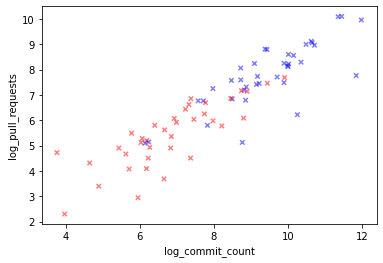

In [ ]:
X_train.plot.scatter(x="log_commit_count", y="log_pull_requests", 
                     c=clusters_c, marker="x", alpha=.5)